In [10]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements.txt

# Restart the runtime by ending the process.
exit()

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, NUM_BANDS, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH
from serving.common import list_blobs_with_prefix
from serving.hist_training import create_hist_dataset, LstmModel, train_and_evaluate, create_data_sample, get_labels
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels
import logging
import io
import itertools
from google.cloud import storage
import google.auth
import time
import os
import matplotlib.pyplot as plt

2024-10-20 23:39:44.231298: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 23:39:44.283040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(feature, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    feature = {
        'feature': _bytes_feature(tf.io.serialize_tensor(feature)),
        'label': _float_feature(label),
    }
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def save_dataset_to_gcp(dataset, bucket_name='vgnn', file_name='hist_dataset_medium.tfrecords'):
    # Initialize GCP client
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Create a local temporary file
    local_file_name = 'temp_' + file_name
    
    # Write the dataset to the local file
    with tf.io.TFRecordWriter(local_file_name) as writer:
        for features, label in dataset:
            example = serialize_example(features, label)
            writer.write(example)
    
    # Upload the local file to GCS
    blob = bucket.blob(f"dataset/{file_name}")
    blob.upload_from_filename(local_file_name)

    # Remove the local temporary file
    os.remove(local_file_name)

    print(f"Dataset saved to gs://{bucket_name}/dataset/{file_name}")
    
def parse_tfrecord_fn(example_proto):
    # Define the features dictionary that matches the structure used when saving
    feature_description = {
        'feature': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.float32)
    }
    
    # Parse the input tf.Example proto using the feature description
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode the feature from the parsed example
    feature = tf.io.parse_tensor(parsed_features['feature'], out_type=tf.float32)
    label = parsed_features['label']
    
    return feature, label

def load_dataset_from_gcp(bucket_name='vgnn', file_name='hist_dataset_medium.tfrecords'):
    # Construct the full GCS path
    gcs_path = f"gs://{bucket_name}/dataset/{file_name}"
    
    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(gcs_path)
    
    # Parse the TFRecords
    parsed_dataset = dataset.map(parse_tfrecord_fn)
    
    return parsed_dataset    

In [3]:
# SETUP

CREATE_DATASET = False

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
batch_size = 30

client = storage.Client()
bucket = client.get_bucket(bucket_name)



In [4]:
if CREATE_DATASET:
    # Generate all prefixes
    start_time = time.perf_counter()
    
    labels_df = get_varied_labels(IMAGE_BATCH)
    labels = list(zip(labels_df["county_name"],
                      labels_df["county_ansi"],
                 labels_df["state_ansi"],
                 labels_df["year"]))

    prefixes = [f'histograms/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                for county,_, fips, year in labels]

    prefixes_hist = [f'histograms/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                for county,_, fips, year in labels]

    # Batch check all prefixes
    results_hist = batch_check_blobs(bucket_name, prefixes)

    # Generate get_input_img_params based on results
    get_input_img_params = [(county.capitalize(), fips, year)
                for county, county_fips, fips, year in labels
                if results_hist[f'histograms/{SCALE}/{county.capitalize()}_{fips}/{year}']
    ]

    print(f"Number of items to process: {len(get_input_img_params)} seconds")
    
    end_time_dataset_info = time.perf_counter()
    print(f"Collecting dataset information: {end_time_dataset_info-start_time}")
    
    dataset, input_shape = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy")
    end_time_dataset = time.perf_counter()
    
    print(f"Building dataset: {end_time_dataset_info - end_time_dataset:.0} seconds")
    
    # Save dataset
    save_dataset_to_gcp(dataset)
    print("Dataset created")
else:
    dataset = load_dataset_from_gcp()
    for features, label in dataset.take(1):
        input_shape = tuple(features.shape)
    print("Dataset loaded")

Dataset loaded


2024-10-20 23:39:47.045040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [5]:
input_shape

(3, 416)

In [6]:
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Sutter'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
66,CORN,YEAR,2016,06,CALIFORNIA,101,SUTTER,264.1,USDA_Corn_County_2016.csv
3045,CORN,YEAR,2018,06,CALIFORNIA,101,SUTTER,210.0,USDA_Corn_County_2018.csv
4389,CORN,YEAR,2019,06,CALIFORNIA,101,SUTTER,147.1,USDA_Corn_County_2019.csv
7314,CORN,YEAR,2021,06,CALIFORNIA,101,SUTTER,169.9,USDA_Corn_County_2021.csv
8791,CORN,YEAR,2022,06,CALIFORNIA,101,SUTTER,133.8,USDA_Corn_County_2022.csv


In [7]:
model = LstmModel(input_shape=(3, 416), lstm_layers=3, no_units=2,)
trained_model, history = train_and_evaluate(model, dataset, epochs=20, initial_learning_rate=10.1, batch_size=batch_size)

2024-10-20 23:39:47.451262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-20 23:39:47.453302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-20 23:39:47.454705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-10-20 23:39:48.150952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-10-20 23:39:48.151310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-10-20 23:39:48.404174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with d

     17/Unknown - 4s 6ms/step - loss: 6381.9321

2024-10-20 23:39:52.000336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-10-20 23:39:52.000692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-10-20 23:39:52.219283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with d

20/20 [==============================] - 5s 83ms/step - loss: 6021.5615 - val_loss: 2049.9277
Epoch 2/20
20/20 [==============================] - 0s 16ms/step - loss: 2556.2664 - val_loss: 2040.6656
Epoch 3/20
20/20 [==============================] - 0s 15ms/step - loss: 2077.9924 - val_loss: 1736.9641
Epoch 4/20
20/20 [==============================] - 0s 15ms/step - loss: 1837.0092 - val_loss: 1923.3700
Epoch 5/20
20/20 [==============================] - 0s 15ms/step - loss: 1877.8552 - val_loss: 1809.0082
Epoch 6/20
20/20 [==============================] - 0s 16ms/step - loss: 1811.8289 - val_loss: 1940.3762
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 1747.4319 - val_loss: 1740.8083
Epoch 8/20
20/20 [==============================] - 0s 16ms/step - loss: 1877.9941 - val_loss: 1892.3909
Epoch 9/20
20/20 [==============================] - 0s 17ms/step - loss: 1849.2872 - val_loss: 2139.6292
Epoch 10/20
20/20 [==============================] - 0s 15ms/step 

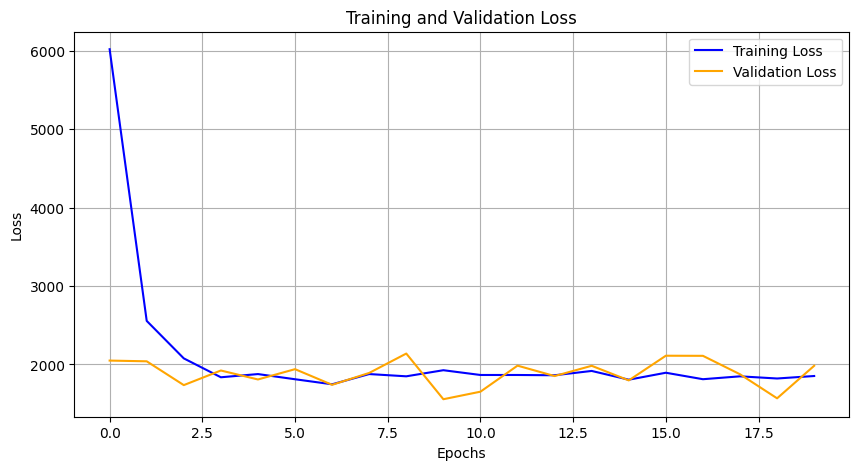

In [8]:
plt.ion()
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [9]:
print(tf.__version__)
print(tf.keras.__version__)

2.12.0
2.12.0
